### LSTM forecasting model with News
https://marketpsych-website.s3.amazonaws.com/web3/files/papers/Forecasting%20the%20USD-JPY%20Rate%20with%20Sentiment.pdf

In [1]:
import sys
import datetime as dt
import math
import numpy as np
import os
from typing import List
import pandas as pd
import tensorflow as tf
import yfinance as yf
import pandas_ta as ta
#import seglearn

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure

from sklearn.model_selection import KFold
from dataclasses import dataclass
from marketpsych import sftp

C:\tools\Anaconda3\envs\env1\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
os.chdir('C:/my_working_env/general_folder/Refinitiv/refinitiv_lstm_test')

パラメータ入力

In [3]:
rms_freq = "W-SUN"      # News data time step.  W-SUN=every_Sunday
price_freq = "1wk"  # Yahoo finance price data time step.   1wk=every_week 
activation_func = ['relu']   
train_verbose = False
use_best_model = True
my_batch_size = None  # use None=len(df) or integer.  
num_folds = 5  # number of train data to split during k-cross validation.  

normalization = "log"   # Choose log, maxmin, ...
n_steps =  5  # Sequence length for the LSTM inputs.
window = 8  # MACD window size.
reduceLR = True   # Option to change learning rate during training.

num_units = [ 10,  20,  30, 40, 50, 60, 70, 80, 90, 100, 110, 120   ]   # number of units in LSTM layer.  
num_layers =  [1, 2,]  # number of LSTM layers.

通貨ペアとニュース指標の指定。rma_file2は未入力でもOK。featuresで選択できるカラムは複数可。

In [4]:
cur = "USDJPY"
rma_file1 = "rma_colab_USD.csv"  # News data for US.
rma_file2 = "rma_colab_JPY.csv"  # News data for JP.
features1 = ["priceDown", "sentiment"]  # Choose the feature for rma_file1.
features2 = ["priceDirection", "sentiment"]  # Choose the feature for rma_file2.  

関数の定義。

In [5]:
def load_csv(file_name:str, news_cols:List[str]) -> pd.DataFrame:
    ''' Load .csv and change format to time column. '''
    rma = pd.read_csv(file_name)
    rma.rename(columns = {'windowTimestamp':'utc_datetime'}, inplace=True)
    rma['utc_datetime'] = pd.to_datetime( rma.utc_datetime, utc=False ) 
    rma.fillna(0, inplace=True)
    for col in news_cols:
        rma[col] = rma[col]/rma[col].max()
    return rma

In [6]:
def apply_macd(rma:pd.DataFrame, news_cols:List[str], window:int, rma_file) -> pd.DataFrame:
    ''' Apply MACD to RMA news columns. '''
    for col in news_cols:
        v = window
        rma_macd = ta.macd( rma[col], fast=v, slow=int(v*26/12), signal=int(v*9/12) )
        rma_macd = rma_macd/rma_macd.max().max()  # rescale with max value.
        rma = pd.concat([rma, rma_macd], axis=1)
        for name in rma_macd.columns:
            rma.rename(columns={ name: rma_file.split(".")[0] + "_" + col + "_" + name }, inplace=True)
    num_macd_cols = 3*len(news_cols) 
    col_names = rma.columns[-num_macd_cols:]
    return rma, list(col_names)

In [7]:
def calc_vol(prices_df):
    ''' Calculate volatility based on high/low price. '''
    return  np.log(prices_df.High/prices_df.Low)/(2.0*np.log(4))

In [8]:
def buzz_weight_rma(rma_df:pd.DataFrame, rms_freq:str) -> pd.DataFrame:
    '''
    Re-aggregates RMAs within a given time frequency. It also flattens the 
    dataframes, so the assets become different columns (if more than one currency is in the data).
    '''
    
    buzz_col="buzz"
    asset_col="assetCode"
    date_col="utc_datetime"

    if date_col in rma_df.columns:
        rma_df[date_col] = pd.to_datetime(pd.to_datetime(rma_df.utc_datetime).dt.strftime('%Y-%m-%d'))
        rma_df = rma_df.set_index(date_col)

    cols_to_ignore = [buzz_col, "mentions", "utc_datetime",  
                      "dataType", "systemVersion", "id", "Date"]
    
    if asset_col in rma_df.columns:
        assets = rma_df[asset_col].unique()
        
        final_df = None
        for asset in assets:
            asset_df = rma_df.query(f"{asset_col} == '{asset}'").drop(columns=[asset_col]).copy()
            
            # Aggregates buzz on the chosen time period.
            temp_df = asset_df[[buzz_col]].groupby(pd.Grouper(freq=rms_freq)).sum().copy()

            for rma in asset_df.columns:
                if rma not in cols_to_ignore:
                    temp_df[rma] = (asset_df[rma]*asset_df[buzz_col]).groupby(pd.Grouper(freq=rms_freq)).sum()   
                    temp_df[rma] = temp_df[rma]/temp_df[buzz_col]
                        
            if final_df is not None:
                final_df = pd.concat([final_df, temp_df], axis=1)
            else:
                final_df = temp_df.copy()
        
        return final_df

In [9]:
def normalize_price(price_df:pd.DataFrame, normalization:str) -> pd.DataFrame:
    '''
    Normalize price.  Currently, either "log" or "maxmin" are
    implemented. (cannot choose both.)  
    '''
    
    if normalization == "log":
        rate_col_name = "rate_log"
        price_df['rate_log'] = np.log(price_df.Open/price_df.Open.shift())*10.0 
        price_df['Fw_' + rate_col_name] = price_df.rate_log.shift(-1) 
    elif normalization == "maxmin":
        if cur == "USDJPY":
            max0 = 150; min0 = 100
        elif cur == "GBPJPY":
            max0 = 150; min0 = 100
        elif cur == "GBPUSD":
            max0 = 1.4; min0 = 1.1
        elif cur == "EURUSD":
            max0 = 1.2; min0 = 1.0
        rate_col_name = "rate_maxmin"
        price_df[rate_col_name] = (price_df.Open - min0)/(max0-min0)
        price_df['Fw_' + rate_col_name] = price_df.rate_maxmin.shift(-1)
    else:
        raise Exception("Currently log or maxmin is available.")

    return price_df, rate_col_name

In [10]:
def split_sequences(sequences, n_steps):
    '''Creates input data with n_steps sequence.'''
    X, y = list(), list()
    for i in range(len(sequences)):
        
        # find the end of this pattern
        end_ix = i + n_steps
        
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
         
        # Get input and target data. Target is 1 day ahead of input data.
        seq_x = sequences[i:end_ix, :]
        seq_y = sequences[end_ix, :]   
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [11]:
def get_pips_result( df, pred_series ):

    def get_pips(x):
        if x.pred_position != x.pred_position_prev:
            if x.pred_position==-1.0:
                return x.Open - x.order_prev
            elif x.pred_position==1.0:
                return x.order_prev - x.Open
        else:
            return 0.0  

    def paper_pips_fun(x):
        if x.paper_position == 1:
            return x.Open - x.open_prev
        elif x.paper_position == -1:
            return x.open_prev - x.Open
        else:
            return 0.0    
    
    if normalization == "log":
        df['prediction'] = np.pad( pred_series, (n_steps-1, 1), constant_values=0)    
        df['pred_position'] = np.sign( df['prediction'] )
    elif normalization == "maxmin":
        df['prediction'] = np.pad( pred_series, (n_steps-1, 1), constant_values=0)
        df['pred_diff'] = df[['rate_maxmin','prediction']].apply( lambda x: x[1]-x[0], axis=1 )
        df['pred_position'] = np.sign( df['pred_diff'] ) 
        
    # keep position until sar_buy/sell
    df['pred_position_prev'] = df.pred_position.shift(periods=1)
    df['order_price'] = df[[ 'pred_position', 'pred_position_prev', 'Open' ]].apply(lambda x: x[2] if x[0]!=x[1] else  np.nan , axis=1)
    df.fillna( method='ffill', inplace=True )
    df['order_prev'] = df.order_price.shift(periods=1)
    df['pips'] = df[['pred_position', 'pred_position_prev', 'Open', 'order_prev']].apply(lambda x: get_pips(x), axis=1)
    df['cum_pips'] = df.pips.cumsum()

    # paper result.  Close position everyday.  
    if normalization == "log":
        df['paper_pred_shifted'] = np.pad( pred_series, (n_steps, 0), constant_values=0 )   # shift predicted log return to next day.
        df['paper_position'] = np.sign( df['paper_pred_shifted']  )   # position is the prediction from previous day.  
        df["logpips"] = df["paper_position"] * df["rate_log"]
        df["paper_logReturn"] = np.exp(df.logpips.cumsum())
    elif normalization == "maxmin":
        df['paper_position'] = df.pred_position.shift(periods=1)
    
    df["open_prev"] = df.Open.shift(periods=1)
    df['paper_pips'] = df[['paper_position', 'Open', 'open_prev']].apply(lambda x: paper_pips_fun(x), axis=1)   # close position everyday.
    df['cum_paper_pips'] = df.paper_pips.cumsum()
    
    # Insert win column.
    df['win'] = df[['paper_pips']].apply( lambda x: 1 if np.sign(x.paper_pips)>0 else 0, axis=1 )
    
    df['actual_position'] = np.sign(df.Open - df.Open.shift())  # actual price change. 
        
    return df

Get price data from yfinance.

In [12]:
# Retrieves weekly price data from yfinance
price_df = yf.download( cur + "=X", interval=price_freq, start="1997-12-29", end="2022-02-27", progress=False)
# Replaces an incorrect price data point with a rough estimate
if cur=="USDJPY":  price_df.loc['2007-11-19', 'High'] = 111  # Fix the bug, the price was greater than 600.

In [13]:
# Add volatility column.
price_df['Vol'] = calc_vol(price_df).shift()

価格データの標準化。

In [14]:
# Normalize price rate.
price_df, rate_col_name = normalize_price(price_df, normalization)

ニュースデータの読み込み、日足から週足に変換、ニュースをMACDに変換。

In [15]:
# Load news data and apply MACD.  You could apply MACD first, then apply buzz_weight.
rma1 = load_csv(rma_file1, features1)
rma1 = buzz_weight_rma(rma1, rms_freq)
rma1, feature_name1 = apply_macd( rma1, features1, window, rma_file1 )

価格とニュースデータを結合。rma_file2があればそれも結合。

In [16]:
combined_df = pd.merge_asof(price_df, rma1, left_index=True, right_index=True)

if rma_file2: 
    rma2 = load_csv(rma_file2, features2)
    rma2 = buzz_weight_rma(rma2, rms_freq)
    rma2, feature_name2 = apply_macd( rma2, features2, window, rma_file2 )
    combined_df = pd.merge_asof(combined_df, rma2, left_index=True, right_index=True)

価格とニュースのグラフ。

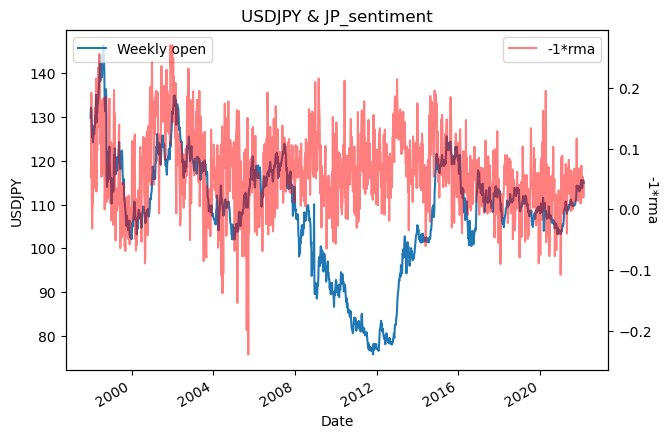

In [17]:
rma_sign = -1
fig, ax = plt.subplots(figsize=(7, 5))
combined_df["Open"].plot(ax=ax, label="Weekly open")
ax.legend(loc='upper left')
ax.set_ylabel(cur)
ax.grid(False)
#ax.set_title(f"USDJPY vs the inverse of the JPY sentiment, corr: \
#   {combined_df[['LogRet','sentiment_JPY']].corr()['LogRet'].iloc[1]:.1%}")
ax.set_title("USDJPY & JP_sentiment")

rma_feature = "sentiment_y"  #combined_df.columns[-1]
ax2 = ax.twinx()
(rma_sign*combined_df[rma_feature]).plot(ax=ax2, color='red', alpha=0.5, label= str(rma_sign)+"*rma" )
ax2.grid(False)
ax2.set_ylabel( str(rma_sign) + "*rma", rotation=270, labelpad=5)
ax2.legend(loc='upper right')
plt.show()
plt.close()

In [18]:
if rma_file2:
    features_list = [rate_col_name] + ["Vol"] + feature_name1 + feature_name2
else:
    features_list = [rate_col_name] + ["Vol"] + feature_name1

print("Features used for training:")
for col in features_list:
    print("- " + col)

Features used for training:
- rate_log
- Vol
- rma_colab_USD_priceDown_MACD_8_17_6
- rma_colab_USD_priceDown_MACDh_8_17_6
- rma_colab_USD_priceDown_MACDs_8_17_6
- rma_colab_USD_sentiment_MACD_8_17_6
- rma_colab_USD_sentiment_MACDh_8_17_6
- rma_colab_USD_sentiment_MACDs_8_17_6
- rma_colab_JPY_priceDirection_MACD_8_17_6
- rma_colab_JPY_priceDirection_MACDh_8_17_6
- rma_colab_JPY_priceDirection_MACDs_8_17_6
- rma_colab_JPY_sentiment_MACD_8_17_6
- rma_colab_JPY_sentiment_MACDh_8_17_6
- rma_colab_JPY_sentiment_MACDs_8_17_6


**特徴量の準備**
 - モデルは回帰、目的変数はt+1の数字

In [19]:
combined_df = combined_df[ features_list ]
combined_df.dropna(inplace=True)  # MACD values may be off the first few rows.  Needs check!!

combined_train = combined_df['1998':'2018'].copy()
combined_test = combined_df['2019':].copy()

combined_df.to_csv("./combined_df.csv", index=None)

# Split data into inputs and targets with proper shapes.
X_train, y_train = split_sequences( combined_train.to_numpy(), n_steps)
X_test, y_test = split_sequences( combined_test.to_numpy(), n_steps)
label_index = 0
y_train = y_train[:, label_index]
y_test  = y_test[:, label_index]

In [20]:
combined_df

,rate_log,Vol,rma_colab_USD_priceDown_MACD_8_17_6,rma_colab_USD_priceDown_MACDh_8_17_6,rma_colab_USD_priceDown_MACDs_8_17_6,rma_colab_USD_sentiment_MACD_8_17_6,rma_colab_USD_sentiment_MACDh_8_17_6,rma_colab_USD_sentiment_MACDs_8_17_6,rma_colab_JPY_priceDirection_MACD_8_17_6,rma_colab_JPY_priceDirection_MACDh_8_17_6,rma_colab_JPY_priceDirection_MACDs_8_17_6,rma_colab_JPY_sentiment_MACD_8_17_6,rma_colab_JPY_sentiment_MACDh_8_17_6,rma_colab_JPY_sentiment_MACDs_8_17_6
Date,,,,,,,,,,,,,,
1998-06-01,0.142001,0.007804,-0.365006,-0.040364,-0.324643,0.111766,-0.136696,0.248462,-0.759439,-0.182636,-0.576803,-0.995616,-0.162718,-0.832898
1998-06-08,0.127171,0.006916,-0.253088,0.051110,-0.304199,0.009733,-0.170520,0.180254,-0.776689,-0.142776,-0.633913,-0.911839,-0.056386,-0.855453
1998-06-15,0.291283,0.012601,-0.314630,-0.007451,-0.307179,0.109665,-0.050420,0.160085,-0.943565,-0.221180,-0.722385,-0.983324,-0.091336,-0.891987
1998-06-22,-0.422070,0.033725,-0.105521,0.144041,-0.249562,-0.026073,-0.132970,0.106897,-0.722586,-0.000143,-0.722442,-0.663181,0.163433,-0.826614
1998-06-29,0.323113,0.015146,-0.200993,0.034693,-0.235685,-0.123923,-0.164872,0.040949,-0.620692,0.072679,-0.693371,-0.605379,0.158025,-0.763404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-24,-0.045595,0.004455,0.164883,0.097686,0.067197,-0.108751,-0.095207,-0.013544,0.089143,0.107266,-0.018122,0.006686,0.019761,-0.013075
2022-01-31,0.126887,0.006866,0.050611,-0.011847,0.062458,-0.045791,-0.023034,-0.022757,-0.120574,-0.073180,-0.047394,-0.023789,-0.007653,-0.016136
2022-02-07,0.000608,0.004345,0.138750,0.054494,0.084256,-0.163560,-0.100574,-0.062987,-0.307138,-0.185531,-0.121607,-0.028766,-0.009021,-0.019744


モデルファイル保存用のディレクトリ作成。

In [21]:
# Creates an ouptut directory for holding results and temp models.
ROOT_DIR = "."
folder_name = 'output'
if not os.path.exists(folder_name):
    os.makedirs(os.path.join(ROOT_DIR, folder_name))
OUT_DIR = os.path.join(ROOT_DIR, folder_name)

ニューラルネットワークLSTMのクラス定義。

In [22]:
@dataclass
class MarketPsychLSTM(object):

    # Default Network settings
    dropout     = 0.2
    loss        = 'mse'
    optimizer   = 'adam'

    # Early stop settings
    es_monitor  = 'val_loss'
    es_mode     = 'min'
    es_patience = 50
    es_verbose  = 0
    mc_filename = 'best_model.h5'
    lr_patience = int(es_patience/2)

    # Fit settings
    max_epoch      = 1000   
    batch_size  = 64
    verbose     = 0
    shuffle     = False
    
    def _build_network(self, X):

        model = tf.keras.models.Sequential()
        if self.nlayers == 0:
            raise ValueError('Number of layers must be at least 1')
        elif self.nlayers == 1:
            model.add(tf.keras.layers.LSTM(self.nunits))
        else:
            for layer in range(self.nlayers-1):
                # Default activation is tanh
                model.add(tf.keras.layers.LSTM(self.nunits, activation=self.activation, 
                              return_sequences=True, 
                              input_shape=(X.shape[1], X.shape[2])))
                model.add(tf.keras.layers.Dropout(self.dropout))
            # Add last hidden layer
            model.add(tf.keras.layers.LSTM(self.nunits))
            
        # Output layer
        model.add(tf.keras.layers.Dense(1))
        model.compile(loss=self.loss, optimizer=self.optimizer)
        # Creates object with model
        self.model = model

    # Early stopping configuration.
    def _early_stopping(self):
        es = tf.keras.callbacks.EarlyStopping(monitor=self.es_monitor, mode=self.es_mode, 
                              verbose=self.es_verbose, patience=self.es_patience)
        mc = tf.keras.callbacks.ModelCheckpoint(os.path.join(OUT_DIR, self.mc_filename), 
                            monitor=self.es_monitor, mode=self.es_mode, 
                            verbose=0, save_best_only=True)
        rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                                    patience=self.lr_patience, verbose=0)
        return es, mc, rlr
    
    def fit_once(self, X, y, val=None):  # used for SHAP plotting.
        self._build_network(X)
        if val is not None:
            es, mc = self._early_stopping()
            if reduceLR:
                callbacks = [es, mc, rlr]
            else:
                callbacks = [es, mc]
        else:
            callbacks = None
        
        history = self.model.fit(X, y, epochs=self.max_epoch, 
                                batch_size=self.batch_size, 
                                use_multiprocessing=True,
                                validation_data=val,
                                verbose=self.verbose,
                                shuffle=self.shuffle,
                                callbacks=callbacks)
        self.history = history
        
        if val is not None:
            self.model = tf.keras.models.load_model(os.path.join(OUT_DIR, self.mc_filename))

    def predict(self, X):
        return self.model.predict(X)
    
    def fit_kfold(self, X, y, num_folds, kfold_verbose=1):
    
        # Builds network
        self._build_network(X)

        # Series with predictions in the validation set
        valid_series  = pd.Series([], dtype='float64')
        # Define the K-fold Cross Validator
        kfold = KFold(n_splits=num_folds, shuffle=False)

        es, mc, rlr = self._early_stopping()
        fold_no = 1
        mse_per_fold = []
        opt_n_epochs = []
        for train, valid in kfold.split(X, y):
            if kfold_verbose:
                print('----------------------------')
                print(f'Training fold {fold_no} ...')

            if reduceLR:
                callback_opt = [es, mc, rlr]
            else:
                callback_opt = [es, mc]

            history = self.model.fit(X[train], y[train],
                                    epochs=self.max_epoch, 
                                    batch_size=self.batch_size, 
                                    use_multiprocessing=True,
                                    validation_data=(X[valid], y[valid]),
                                    verbose=self.verbose,
                                    shuffle=False, callbacks=callback_opt
                                    )
        
            # Load the best saved model.
            saved_model = tf.keras.models.load_model(os.path.join(OUT_DIR, self.mc_filename))
            self.model = saved_model
            opt_epochs = len(history.history['val_loss'])
            opt_n_epochs.append(opt_epochs)
            if kfold_verbose:
                print(f'Epochs used: {opt_epochs}')

            scores = saved_model.evaluate(X[valid], y[valid], verbose=0)
            
            if kfold_verbose:
                print('RMSE for fold {:d}: {:>7.4}'.format(fold_no, np.sqrt(scores)))
            mse_per_fold.append(scores)
            
            temp_sr = pd.Series(np.squeeze(saved_model.predict(X[valid], verbose=0)), index=valid)
            valid_series = pd.concat([valid_series, temp_sr])

            # Increase fold number
            fold_no = fold_no + 1

        mse_per_fold = np.array(mse_per_fold)
        if kfold_verbose:
            print('Avg. RMSE: {:>7.4f}'.format(np.sqrt(mse_per_fold).mean()))
        return mse_per_fold, opt_n_epochs, valid_series

def plot_lstm_history(history, init_step=0):
    ''' Plot learning history. '''
    for key in history.history.keys():
        plt.plot(history.history[key][init_step:], label=key)
    plt.xlabel('# epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

num_units, num_layers, activation_funcすべてのパラメータを検証、RMSEの値が１番低いモデルを採用。

In [23]:
#import random
#random.seed(52)
#tf.random.set_seed(52)
tf.keras.utils.set_random_seed(52)

model = MarketPsychLSTM()
if my_batch_size == None:
    model.batch_size = len(X_train)
elif isinstance( my_batch_size, int ):
    model.batch_size = my_batch_size

rmse_list = [1.0e10]  # Initialize with some large numeber.
for nunits in num_units:
    for nlayers in num_layers:
        for activation in activation_func:
            model.nunits = nunits
            model.nlayers =  nlayers
            model.activation = activation

            # Runs a few times due to the stochastic character of the model
            mse_folds, _, _ = model.fit_kfold(X_train, y_train, num_folds, kfold_verbose=train_verbose)
            
            mean_rmse = np.mean(np.sqrt(np.array(mse_folds)))
            print(f" Num_units = {str(nunits)},  Num_layers = {str(nlayers)}, Activation = {activation}, AVG_RMSE = {mean_rmse}")
            if mean_rmse < min(rmse_list):
                best_model = { 'Num_units':nunits, 'Num_layers':nlayers, 'Activation':activation }
            
            rmse_list.append(mean_rmse)

print(); print(f" Best model is: {best_model}" )

 Num_units = 10,  Num_layers = 1, Activation = relu, AVG_RMSE = 0.16745930797621672
 Num_units = 10,  Num_layers = 2, Activation = relu, AVG_RMSE = 0.16617989892471513
 Num_units = 20,  Num_layers = 1, Activation = relu, AVG_RMSE = 0.1677340828907981
 Num_units = 20,  Num_layers = 2, Activation = relu, AVG_RMSE = 0.16666806927390715
 Num_units = 30,  Num_layers = 1, Activation = relu, AVG_RMSE = 0.16528280893334826
 Num_units = 30,  Num_layers = 2, Activation = relu, AVG_RMSE = 0.16606514947677117
 Num_units = 40,  Num_layers = 1, Activation = relu, AVG_RMSE = 0.16505625929624465
 Num_units = 40,  Num_layers = 2, Activation = relu, AVG_RMSE = 0.16561420318135425
 Num_units = 50,  Num_layers = 1, Activation = relu, AVG_RMSE = 0.1651956126694411
 Num_units = 50,  Num_layers = 2, Activation = relu, AVG_RMSE = 0.1664515208406969
 Num_units = 60,  Num_layers = 1, Activation = relu, AVG_RMSE = 0.16467536882658457
 Num_units = 60,  Num_layers = 2, Activation = relu, AVG_RMSE = 0.1663220226184

RMSEが低かったモデルを再作成。結果をCSVファイルに保存。

In [24]:
# Based on the above result, the lowest RMSE was the following params.  
if use_best_model:
    subtitle = "Using the best params"
    model.nunits = best_model['Num_units']
    model.nlayers =  best_model['Num_layers']   
    model.activation = best_model['Activation']
else:
    subtitle = "Using default params"
    model.nunits = 15  
    model.nlayers =  2   
    model.activation = "relu"

#import random
#random.seed(52)
#tf.random.set_seed(52)
tf.keras.utils.set_random_seed(52)

# Get Open price in data.  
combined_train = pd.merge_asof( combined_train,  price_df['Open'], left_index=True, right_index=True )

# Reruns the model with the chosen configuration.
# yhat_train is the predicted LogReturn using validation data.
print();  print( subtitle + " to train the model again...")
_, _, pred_train = model.fit_kfold(X_train, y_train, num_folds, kfold_verbose=False)  
combibned_train = get_pips_result( combined_train, pred_train.values )

# plot cum_pips, paper_logReturn, cum_paper_pips.  paper_logReturn reproduces the paper.  
combined_train.to_csv('./output_train.csv', index=None)
print("Done.  Saving the validation result.")


Using the best params to train the model again...
Done.  Saving the validation result.


**ストラテジー:**　
 - t+1予測の値がプラスなら買い、マイナスなら売り。

テストデータで検証。結果を保存。

In [25]:
combined_test = pd.merge_asof( combined_test,  price_df['Open'], left_index=True, right_index=True )

pred_test = model.predict(X_test)

combibned_test = get_pips_result( combined_test, np.squeeze(pred_test) )
combined_test.to_csv('./output_test.csv', index=None)
print("Now, saving the test resut.")

5/5 [==============================] - 0s 2ms/step
Now, saving the test resut.


勝率の計算。

In [26]:
win_pct_val = np.round( combined_train.win.sum()/(len(combined_train)-1), 2) 
win_pct_forward = np.round( combined_test.win.sum()/(len(combined_test)-1), 2) 
print(); print(f" win_pct(val) = {str(win_pct_val)},  win_pct(forward) = {str(win_pct_forward)}")


 win_pct(val) = 0.52,  win_pct(forward) = 0.54


**ケース１**
 - 毎週決済


Validationデータでpips検証。

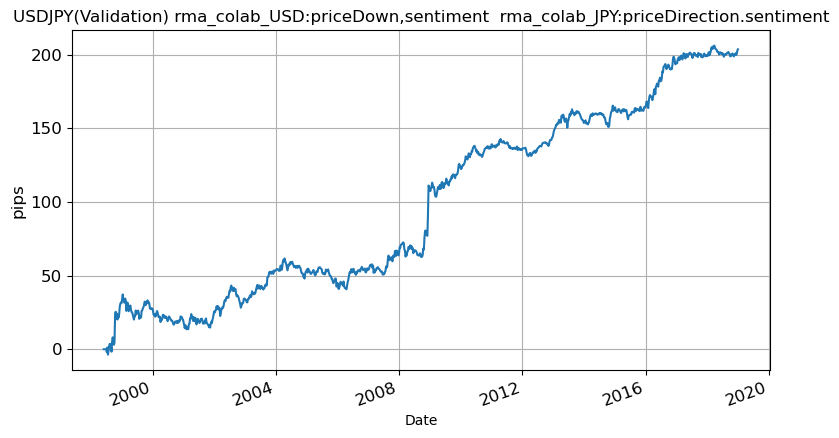

In [27]:
if rma_file2:
    title = cur + "(Validation) " + rma_file1.split(".")[0] + ':' + ','.join(features1[0:]) + '  ' + rma_file2.split(".")[0] + ':' + '.'.join(features2[0:])
else:
    title = cur + " (Validation) " + rma_file1.split(".")[0] + ':' + ','.join(features1[0:])

font_size = 12
figure(num=None, figsize=(9, 5), facecolor='w', edgecolor='k')  
combined_train.cum_paper_pips.plot()
plt.title( title,  fontsize=font_size )
plt.xticks( fontsize=font_size, rotation=20 );
plt.yticks( fontsize=font_size ) 
plt.ylabel( 'pips',  fontsize=font_size)
#plt.text( combined_train.index[10] , 5 , 'win_pct = ' + str(win_pct_val), fontsize=12 )
plt.grid()
plt.show()
plt.savefig('./validation.png',  dpi=100)
plt.close()

テストデータで検証。

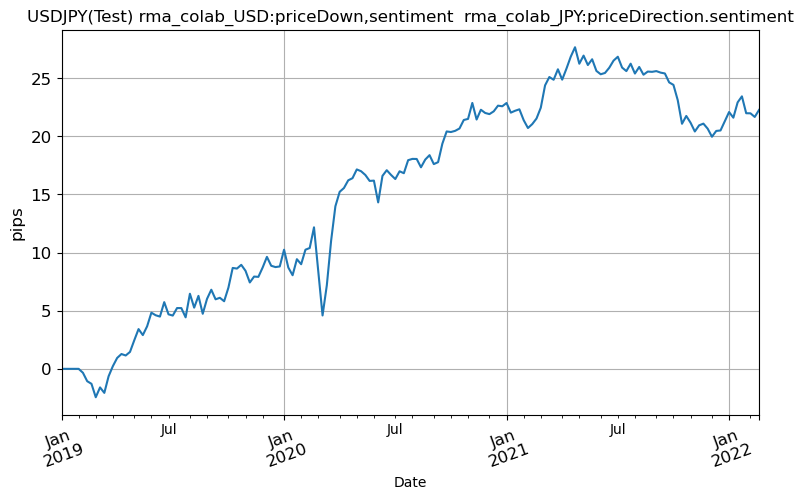

In [28]:
if rma_file2:
    title = cur + "(Test) " + rma_file1.split(".")[0] + ':' + ','.join(features1[0:]) + '  ' + rma_file2.split(".")[0] + ':' + '.'.join(features2[0:])
else:
    title = cur + " (Test) " + rma_file1.split(".")[0] + ':' + ','.join(features1[0:])

figure(num=None, figsize=(9, 5), facecolor='w', edgecolor='k') 
combined_test.cum_paper_pips.plot()
plt.title( title, fontsize=font_size )
plt.xticks( fontsize=font_size, rotation=20 );
plt.yticks( fontsize=font_size ) 
plt.ylabel( 'pips', fontsize=font_size)
#plt.text( combined_test.index[10] , 5 , 'win_pct = ' + str(win_pct_forward), fontsize=12 )
plt.grid()
plt.show()
plt.savefig('./forward.png', dpi=100)
plt.close()

Confusion Matrixのチェック。

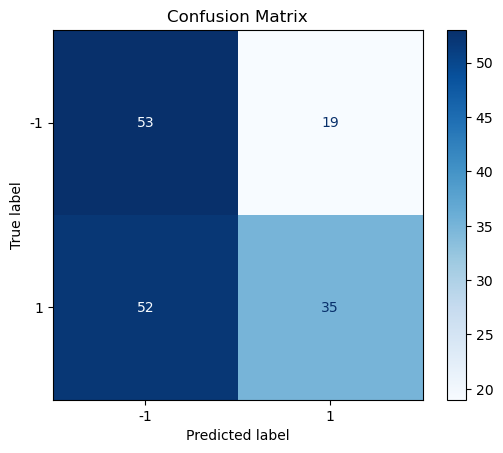

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate confusion matrix
true_label = combined_test.actual_position.dropna().values
pred_label = combined_test.pred_position_prev.dropna().values
cm = confusion_matrix( true_label, pred_label, labels=[-1, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['-1', '1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
plt.close()

**ケース２**
 - ポジションが前週と同じ場合は決済しない（ポジションは継続）

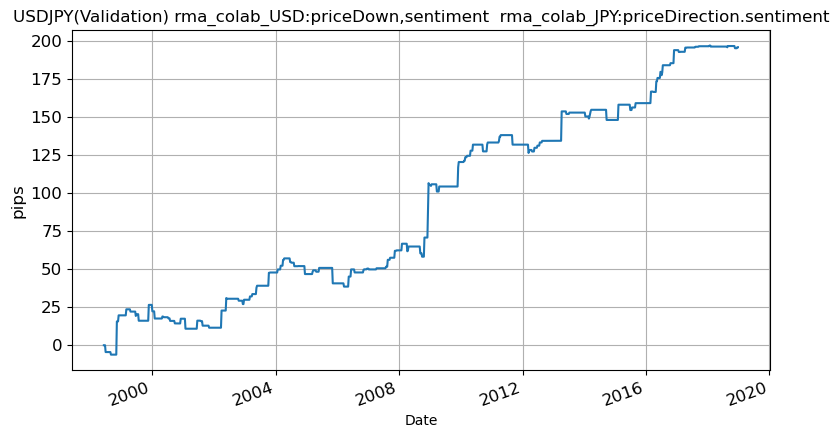

In [30]:
if rma_file2:
    title = cur + "(Validation) " + rma_file1.split(".")[0] + ':' + ','.join(features1[0:]) + '  ' + rma_file2.split(".")[0] + ':' + '.'.join(features2[0:])
else:
    title = cur + " (Validation) " + rma_file1.split(".")[0] + ':' + ','.join(features1[0:])

font_size = 12
figure(num=None, figsize=(9, 5), facecolor='w', edgecolor='k')  
combined_train.cum_pips.plot()
plt.title( title,  fontsize=font_size )
plt.xticks( fontsize=font_size, rotation=20 );
plt.yticks( fontsize=font_size ) 
plt.ylabel( 'pips',  fontsize=font_size)
#plt.text( combined_train.index[10] , 5 , 'win_pct = ' + str(win_pct_val), fontsize=12 )
plt.grid()
plt.show()
plt.savefig('./validation.png',  dpi=100)
plt.close()

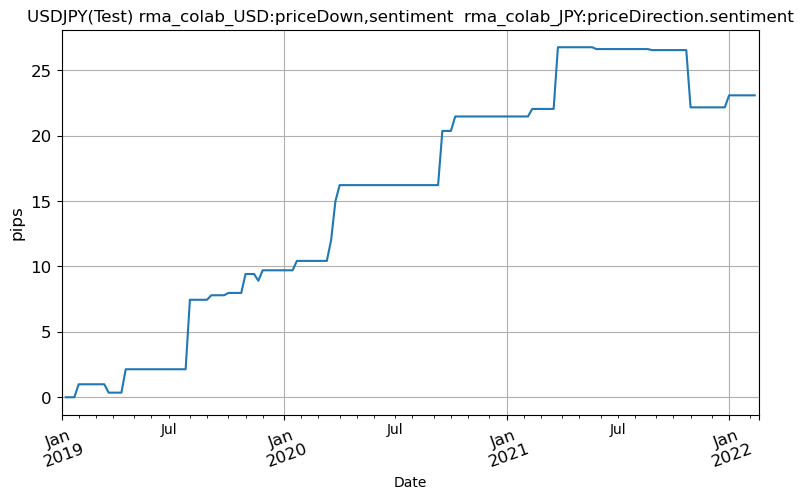

In [31]:
if rma_file2:
    title = cur + "(Test) " + rma_file1.split(".")[0] + ':' + ','.join(features1[0:]) + '  ' + rma_file2.split(".")[0] + ':' + '.'.join(features2[0:])
else:
    title = cur + " (Test) " + rma_file1.split(".")[0] + ':' + ','.join(features1[0:])

figure(num=None, figsize=(9, 5), facecolor='w', edgecolor='k') 
combined_test.cum_pips.plot()
plt.title( title, fontsize=font_size )
plt.xticks( fontsize=font_size, rotation=20 );
plt.yticks( fontsize=font_size ) 
plt.ylabel( 'pips', fontsize=font_size)
#plt.text( combined_test.index[10] , 5 , 'win_pct = ' + str(win_pct_forward), fontsize=12 )
plt.grid()
plt.show()
plt.savefig('./forward.png', dpi=100)
plt.close()

Shapを使いFeature Importanceを可視化。

Instructions for updating:
non-resource variables are not supported in the long term


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


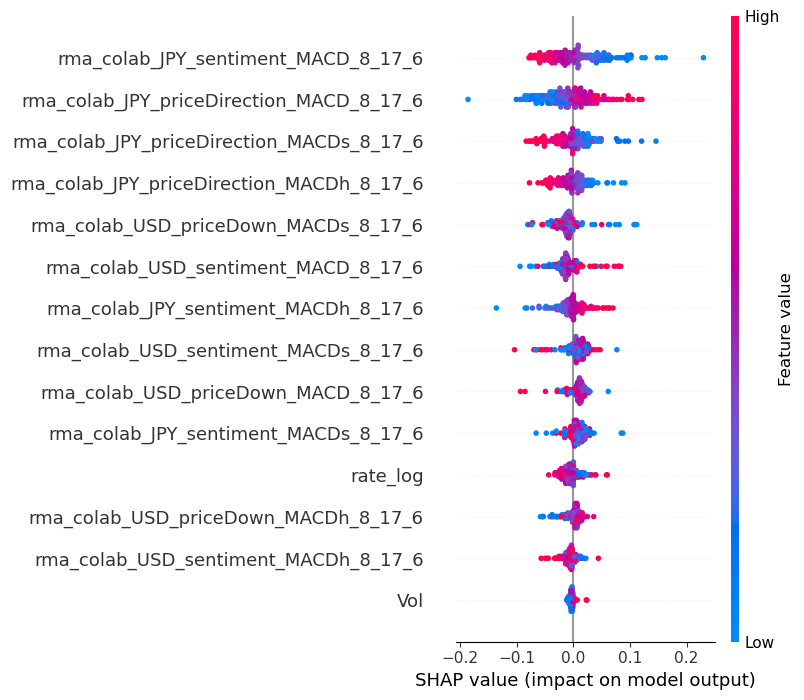

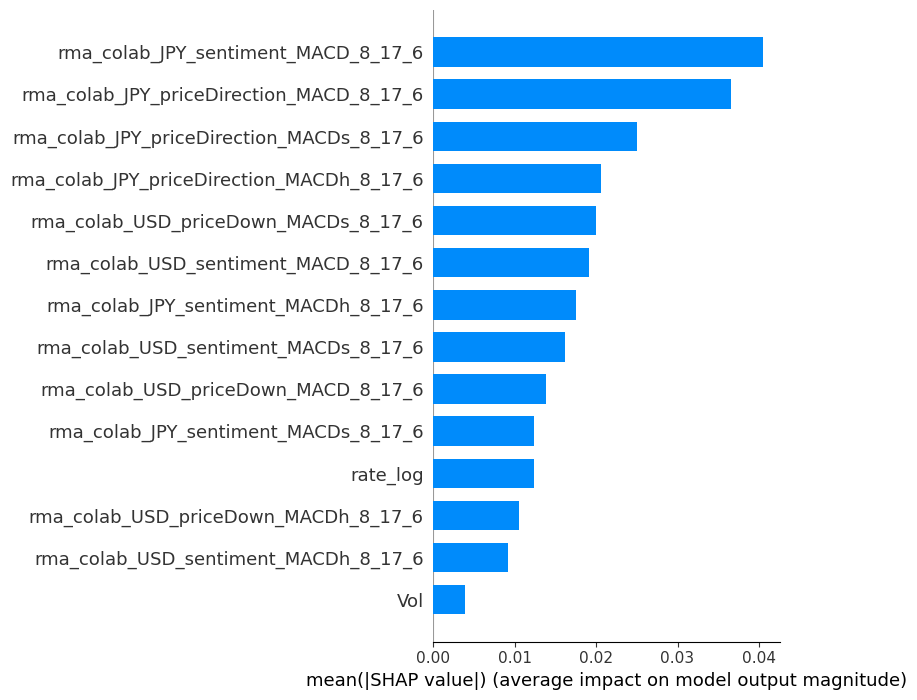

In [32]:
import shap

# SHAP not currently working with TF >2.5.  Version needs to be adjusted.
tf.compat.v1.disable_v2_behavior()

#tf.random.set_seed(52)   # For older version of tensorflow.  
tf.keras.utils.set_random_seed(52)   # For newer version tensorflow use this.

model.fit_once(X_train, y_train)

shap.initjs()
explainer = shap.DeepExplainer(model.model, X_train)
shap_values = explainer.shap_values(X_test)

features =  features_list

if n_steps >= 2:
    # https://stackoverflow.com/questions/60894506/shap-lstm-keras-tensorflow-valueerror-shape-mismatch-objects-cannot-be-broa
    shap.summary_plot( np.squeeze(shap_values)[:, 0, :], np.squeeze(X_test)[:, 0, :], features )
    shap.summary_plot( np.squeeze(shap_values)[:, 0, :], np.squeeze(X_test)[:, 0, :], features, plot_type='bar' )
else:
    shap.summary_plot( np.squeeze(shap_values), np.squeeze(X_test), features )
    shap.summary_plot( np.squeeze(shap_values), np.squeeze(X_test), features, plot_type='bar' )
